# Introduction to Bias and Fairness in Machine Learning

In this tutorial, we will explore the topic of bias in machine learning. More specifically, we will be exploring the UCI Adult dataset to learn about metrics for quantifying bias, as well as methods for mitigating demographic bias from machine Learning predictions.


### Software requirements

In this tutorial, you will need **numpy, pandas, skit-learn, tensorflow and keras**, which are all the machine learning tools that you will be needing in this notebook. If you don't have them installed on your machine, you can learn the tutorial on [Google's colab](https://colab.research.google.com), which has all the tools pre-installed

# 1. Analysing data distributions

In this section, we will look through the data that we have. This will give us an idea of the underlying distributions of the data among different demographics.

Load needed modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

** Load the dataset **

For this step, get the pre-processed adult dataset from [our github repository](https://github.com/heyaudace/ml-bias-fairness/blob/master/data/adult/adult.csv), and store it into your local machine

In [2]:
import os
ADULT_PATH = os.path.join(os.getcwd(), 'data/adult/adult.csv') # Assign this to the location of the dataset

In [3]:
data = pd.read_csv(ADULT_PATH)
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [4]:
# Ge the shape of the data
data.shape

(48842, 15)

Let's understand the amount of data by we have, by seeing how the number of datapoints compares among different demographics

In [5]:
def plot_categs(df, category, fignum=1, title="Histogram of number of datapoints"):
    plt.figure(fignum)
    uniques= list(sorted(df[category].unique()))
    counts = [df[df[category] == value].shape[0] for value in uniques]
    size = len(uniques)
    xcoords = list(range(1, size+1))
    plt.bar(xcoords, counts)
    plt.xticks(xcoords, uniques, rotation='vertical' if size >= 5 else 'horizontal')
    plt.title((title if title is not None else ''))
    plt.tight_layout()

## Sex, Race and Native Country

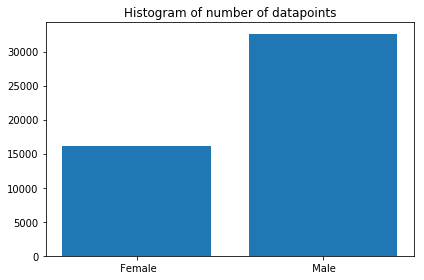

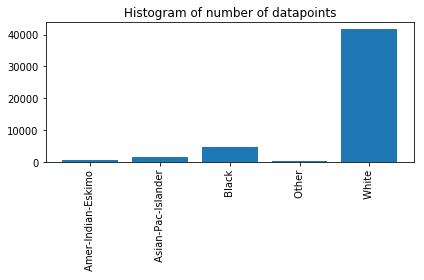

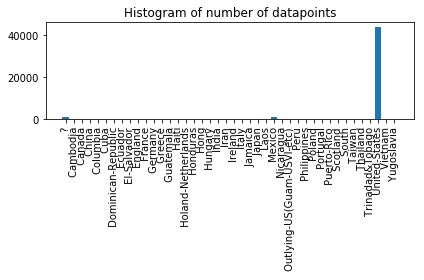

In [6]:
features = ['sex', 'race', 'native-country']
for index, feature in enumerate(features):
    plot_categs(data, feature, fignum=index+1)

# Distribution of education level and occupation

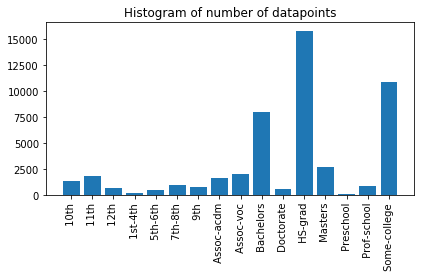

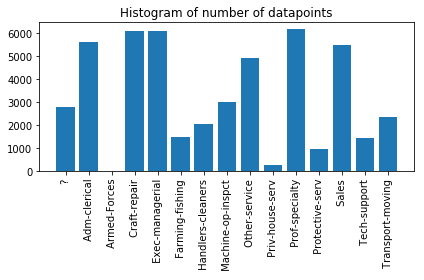

In [7]:
other_features = ['education', 'occupation']
for index, feature in enumerate(other_features):
    plot_categs(data, feature, fignum=index+1)

# Distribution of salary among the general population

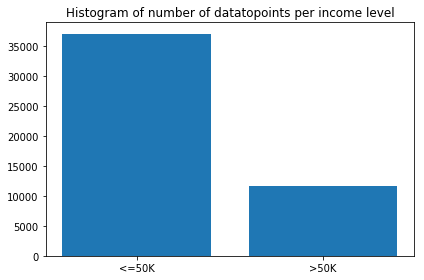

In [8]:
plot_categs(data, 'salary', title="Histogram of number of datatopoints per income level")

## CHECKPOINT 

** Observation ** : The fraction of the population that makes less than 50K is about 3 times the fraction of the
population that earns more than 50K.

** THINK ** : How would this affect the predictor trained on this data?

# Distribution of salary among sex

Let's now explore the distribution of salary among people of Male sex versus people with Female sex

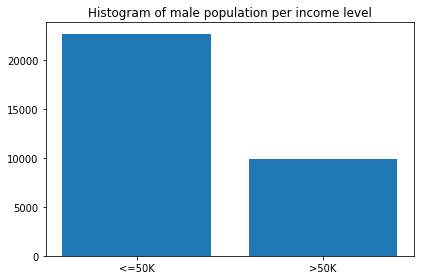

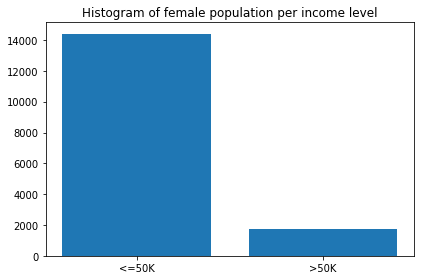

In [9]:
# Examining statistics among_demographics
male_data = data[data.sex == ' Male']
female_data = data[data.sex == ' Female']

plot_categs(male_data, 'salary', fignum=1,title="Histogram of male population per income level")
plot_categs(female_data, 'salary', fignum=2, title="Histogram of female population per income level")

# CHECKPOINT:

**Observation** 
- Fraction of males who make less than \$50K is about twice the fraction of males that make more
- The fraction of females that make less than \$50K is about 7 times the fraction of females that make more

**THINK**: How would this affect the way a predictor trained on this training data treats females versus males? 

## Distribution of race in the dataset

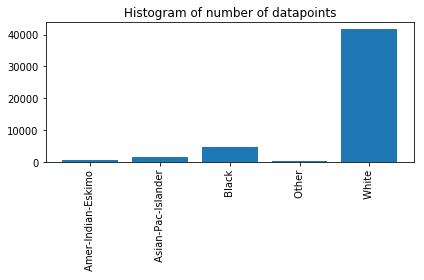

In [10]:
# Examine races in the dataset
plot_categs(data, 'race')

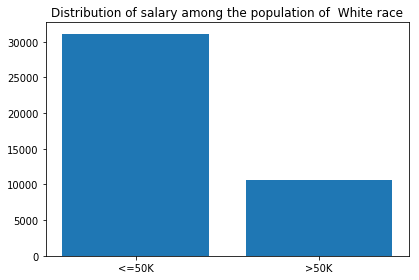

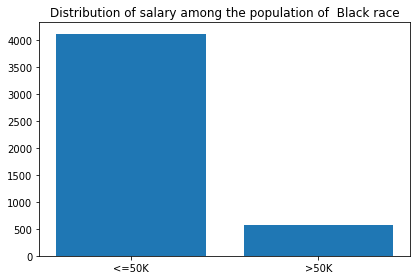

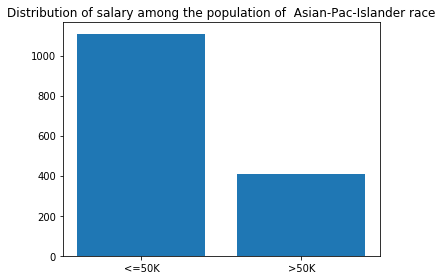

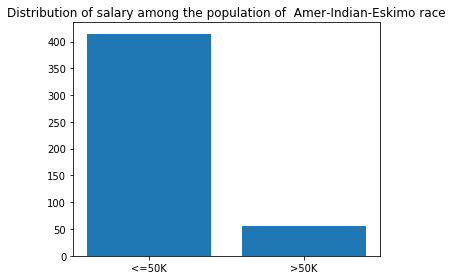

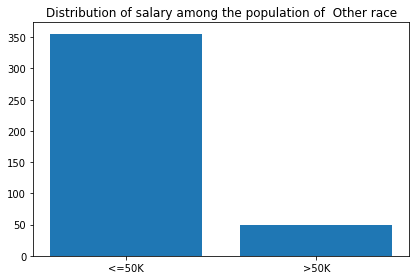

In [11]:
unique_races = data['race'].unique()
for index, race in enumerate(unique_races):
    plot_categs(data[data['race'] == race], 'salary', fignum=index, title = "Distribution of salary among the population of "+race+" race")

# CHECKPOINT
**Observation**:
- Different races have different levels of representation in terms number of datapoints with a given race
- The levels of income distribution among a given race are different 

**THINK**:
- How could this affect the predictions of an algorithm accross different races?

#  Distribution of hours per week

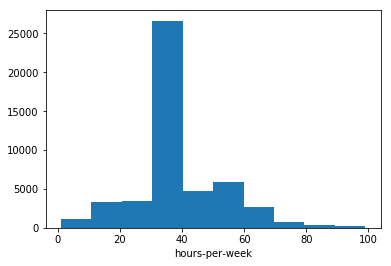

In [12]:
def plot_categ_hists(df, feature, title=None, bins=None, histtype='bar', density=False, normed=None, fignum=1):
    plt.figure(fignum)
    x = df[feature]
    plt.hist(x, bins=bins, density=density, normed=normed, histtype=histtype)
    plt.xlabel(feature)
    plt.title(title if title is not None else '')
plot_categ_hists(data, 'hours-per-week', fignum=1)

# 2. Preparing data training and predictions

One important step in data science before applying machine learning algorithms is data preparation. In this section, we will be transforming features of our data, so that our dataset can be ready for machine learning

In [13]:
# Create a new dataset to be modified 
datav2 = data.copy()
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Drop missing values
Some of the entries in our dataset are either question marks (' ?') or np.nan. Let's simply ignore such entries

In [14]:
# See features with question marks
[feature for feature in datav2.columns if ' ?' in datav2[feature].unique() or np.nan in datav2[feature].unique()]

/Users/audace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


['workclass', 'occupation', 'native-country']

In [15]:
# Remove all missing values
for feature in datav2.columns:
    datav2[feature] = datav2[feature].replace(' ?', np.nan)
datav2.dropna(how='any', inplace=True)

datav2['native-country'].unique(), datav2['workclass'].unique(), datav2['occupation'].unique()

(array([' United-States', ' Cuba', ' Jamaica', ' India', ' Mexico',
        ' Puerto-Rico', ' Honduras', ' England', ' Canada', ' Germany',
        ' Iran', ' Philippines', ' Poland', ' Columbia', ' Cambodia',
        ' Thailand', ' Ecuador', ' Laos', ' Taiwan', ' Haiti', ' Portugal',
        ' Dominican-Republic', ' El-Salvador', ' France', ' Guatemala',
        ' Italy', ' China', ' South', ' Japan', ' Yugoslavia', ' Peru',
        ' Outlying-US(Guam-USVI-etc)', ' Scotland', ' Trinadad&Tobago',
        ' Greece', ' Nicaragua', ' Vietnam', ' Hong', ' Ireland',
        ' Hungary', ' Holand-Netherlands'], dtype=object),
 array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
        ' Local-gov', ' Self-emp-inc', ' Without-pay'], dtype=object),
 array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
        ' Prof-specialty', ' Other-service', ' Sales', ' Transport-moving',
        ' Farming-fishing', ' Machine-op-inspct', ' Tech-support',
        ' Craft-repai

## Categorize native country as US and Non-US

In [16]:
datav2[datav2['native-country'] == ' United-States'].shape

(41292, 15)

In [17]:
datav2.loc[datav2['native-country']!=' United-States', 'native-country'] = 'Non-US'
datav2.loc[datav2['native-country'] == ' United-States', 'native-country'] = 'US'
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,US,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,US,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,US,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,US,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Non-US,<=50K


# Convert native-country, sex and salary to binary one-hot

In [18]:
FEMALE_LABEL, MALE_LABEL = (0, 1)
US_LABEL, NON_US_LABEL = (0, 1)
HIGH_SALARY_LABEL, LOW_SALARY_LABEL = (0, 1)

In [19]:
datav2['salary'] = datav2['salary'].map({'>50K':HIGH_SALARY_LABEL,'<=50K':LOW_SALARY_LABEL})
datav2['native-country'] = datav2['native-country'].map({'US':US_LABEL,'Non-US':NON_US_LABEL}).astype(int)
datav2['sex'] = datav2['sex'].map({' Male':MALE_LABEL,' Female':FEMALE_LABEL})
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,1,2174.0,0.0,40.0,0,1
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,1,0.0,0.0,13.0,0,1
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,1,0.0,0.0,40.0,0,1
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,0.0,0.0,40.0,0,1
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,0,0.0,0.0,40.0,1,1


# Change marital status to single or couple

In [20]:
datav2['marital-status'].unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

In [21]:
datav2['marital-status'] = datav2['marital-status'].replace([' Divorced',' Married-spouse-absent',' Never-married',' Separated',' Widowed'],'Single')
datav2['marital-status'] = datav2['marital-status'].replace([' Married-AF-spouse',' Married-civ-spouse'],'Couple')
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,Single,Adm-clerical,Not-in-family,White,1,2174.0,0.0,40.0,0,1
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Couple,Exec-managerial,Husband,White,1,0.0,0.0,13.0,0,1
2,38,Private,215646.0,HS-grad,9.0,Single,Handlers-cleaners,Not-in-family,White,1,0.0,0.0,40.0,0,1
3,53,Private,234721.0,11th,7.0,Couple,Handlers-cleaners,Husband,Black,1,0.0,0.0,40.0,0,1
4,28,Private,338409.0,Bachelors,13.0,Couple,Prof-specialty,Wife,Black,0,0.0,0.0,40.0,1,1


In [22]:
COUPLE_STATUS_LABEL, SINGLE_STATUS_LABEL = (0, 1)
datav2['marital-status'] = datav2['marital-status'].map({'Couple':COUPLE_STATUS_LABEL,'Single':SINGLE_STATUS_LABEL})
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,1,Adm-clerical,Not-in-family,White,1,2174.0,0.0,40.0,0,1
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,0,Exec-managerial,Husband,White,1,0.0,0.0,13.0,0,1
2,38,Private,215646.0,HS-grad,9.0,1,Handlers-cleaners,Not-in-family,White,1,0.0,0.0,40.0,0,1
3,53,Private,234721.0,11th,7.0,0,Handlers-cleaners,Husband,Black,1,0.0,0.0,40.0,0,1
4,28,Private,338409.0,Bachelors,13.0,0,Prof-specialty,Wife,Black,0,0.0,0.0,40.0,1,1


# Convert relationships to one-hot

Remember that one-hot encoding helps us represent data of multiple categories. Let's do this for relationships

In [23]:
# First convert relationship to integers
rel_map = {' Unmarried':0,' Wife':1,' Husband':2,' Not-in-family':3,' Own-child':4,' Other-relative':5}
datav2['relationship'] = datav2['relationship'].map(rel_map)
datav2.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,1,Adm-clerical,3,White,1,2174.0,0.0,40.0,0,1
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,0,Exec-managerial,2,White,1,0.0,0.0,13.0,0,1
2,38,Private,215646.0,HS-grad,9.0,1,Handlers-cleaners,3,White,1,0.0,0.0,40.0,0,1
3,53,Private,234721.0,11th,7.0,0,Handlers-cleaners,2,Black,1,0.0,0.0,40.0,0,1
4,28,Private,338409.0,Bachelors,13.0,0,Prof-specialty,1,Black,0,0.0,0.0,40.0,1,1
5,37,Private,284582.0,Masters,14.0,0,Exec-managerial,1,White,0,0.0,0.0,40.0,0,1
6,49,Private,160187.0,9th,5.0,1,Other-service,3,Black,0,0.0,0.0,16.0,1,1
7,52,Self-emp-not-inc,209642.0,HS-grad,9.0,0,Exec-managerial,2,White,1,0.0,0.0,45.0,0,0
8,31,Private,45781.0,Masters,14.0,1,Prof-specialty,3,White,0,14084.0,0.0,50.0,0,0
9,42,Private,159449.0,Bachelors,13.0,0,Exec-managerial,2,White,1,5178.0,0.0,40.0,0,0


In [24]:
# Now convert relationship from integer to one-hot
datav2 = pd.get_dummies(datav2, columns=['relationship'])
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,relationship_0,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5
0,39,State-gov,77516.0,Bachelors,13.0,1,Adm-clerical,White,1,2174.0,0.0,40.0,0,1,0,0,0,1,0,0
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,0,Exec-managerial,White,1,0.0,0.0,13.0,0,1,0,0,1,0,0,0
2,38,Private,215646.0,HS-grad,9.0,1,Handlers-cleaners,White,1,0.0,0.0,40.0,0,1,0,0,0,1,0,0
3,53,Private,234721.0,11th,7.0,0,Handlers-cleaners,Black,1,0.0,0.0,40.0,0,1,0,0,1,0,0,0
4,28,Private,338409.0,Bachelors,13.0,0,Prof-specialty,Black,0,0.0,0.0,40.0,1,1,0,1,0,0,0,0


##  Convert race to one-hot

As we did for relationships, we know convert race representation to one-hot encoding

In [25]:
# Convert to integers first
race_map={' White':0,' Amer-Indian-Eskimo':1,' Asian-Pac-Islander':2,' Black':3,' Other':4}
datav2['race']= datav2['race'].map(race_map)
# Convert from integer to one_hot
datav2 = pd.get_dummies(datav2, columns=['race'])
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,sex,capital-gain,capital-loss,...,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5,race_0,race_1,race_2,race_3,race_4
0,39,State-gov,77516.0,Bachelors,13.0,1,Adm-clerical,1,2174.0,0.0,...,0,0,1,0,0,1,0,0,0,0
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,0,Exec-managerial,1,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
2,38,Private,215646.0,HS-grad,9.0,1,Handlers-cleaners,1,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0
3,53,Private,234721.0,11th,7.0,0,Handlers-cleaners,1,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
4,28,Private,338409.0,Bachelors,13.0,0,Prof-specialty,0,0.0,0.0,...,1,0,0,0,0,0,0,0,1,0


# Transform workclass feature

We first start by categorizing workclass as government, private or without pay

In [26]:
def group_workclass(x):
    if x['workclass'] == ' Federal-gov' or x['workclass']== ' Local-gov' or x['workclass']==' State-gov': return 'govt'
    elif x['workclass'] == ' Private':return 'private'
    elif x['workclass'] == ' Self-emp-inc' or x['workclass'] == ' Self-emp-not-inc': return 'self_employed'
    else: return 'without_pay'
    
datav2['workclass']=datav2.apply(group_workclass, axis=1)

datav2['workclass'] = datav2['workclass'].map({'govt':0,'private':1,'self_employed':2,'without_pay':3})
datav2 = pd.get_dummies(datav2, columns=['workclass'])
datav2.head()

,age,fnlwgt,education,education-num,marital-status,occupation,sex,capital-gain,capital-loss,hours-per-week,...,relationship_5,race_0,race_1,race_2,race_3,race_4,workclass_0,workclass_1,workclass_2,workclass_3
0,39,77516.0,Bachelors,13.0,1,Adm-clerical,1,2174.0,0.0,40.0,...,0,1,0,0,0,0,1,0,0,0
1,50,83311.0,Bachelors,13.0,0,Exec-managerial,1,0.0,0.0,13.0,...,0,1,0,0,0,0,0,0,1,0
2,38,215646.0,HS-grad,9.0,1,Handlers-cleaners,1,0.0,0.0,40.0,...,0,1,0,0,0,0,0,1,0,0
3,53,234721.0,11th,7.0,0,Handlers-cleaners,1,0.0,0.0,40.0,...,0,0,0,0,1,0,0,1,0,0
4,28,338409.0,Bachelors,13.0,0,Prof-specialty,0,0.0,0.0,40.0,...,0,0,0,0,1,0,0,1,0,0


# Convert occupation to one-hot

In [27]:
occupation_map = dict((value, key) for (key, value) in enumerate(datav2.occupation.unique()))
datav2['occupation'] = datav2['occupation'].map(occupation_map)
datav2 = pd.get_dummies(datav2, columns=['occupation'])
datav2.head()

,age,fnlwgt,education,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
0,39,77516.0,Bachelors,13.0,1,1,2174.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,83311.0,Bachelors,13.0,0,1,0.0,0.0,13.0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,215646.0,HS-grad,9.0,1,1,0.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
3,53,234721.0,11th,7.0,0,1,0.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
4,28,338409.0,Bachelors,13.0,0,0,0.0,0.0,40.0,1,...,0,0,0,0,0,0,0,0,0,0


##  Convert capita-gain and capital-loss to categorical

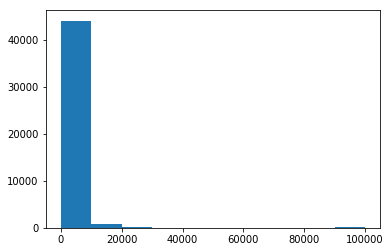

In [28]:
capital_gain, capital_loss, =datav2['capital-gain'], datav2['capital-loss']
plt.hist(capital_gain,bins=None,normed=None)
plt.show()

In [29]:
datav2.loc[(datav2['capital-gain'] > 0),'capital-gain'] = 1
datav2.loc[(datav2['capital-gain'] == 0 ,'capital-gain')]= 0
datav2.head()

,age,fnlwgt,education,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
0,39,77516.0,Bachelors,13.0,1,1,1.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,83311.0,Bachelors,13.0,0,1,0.0,0.0,13.0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,215646.0,HS-grad,9.0,1,1,0.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
3,53,234721.0,11th,7.0,0,1,0.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
4,28,338409.0,Bachelors,13.0,0,0,0.0,0.0,40.0,1,...,0,0,0,0,0,0,0,0,0,0


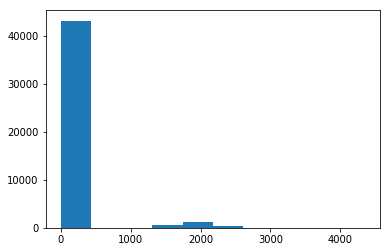

In [30]:
x=datav2['capital-loss']
plt.hist(x,bins=None)
plt.show()

In [31]:
datav2.loc[(datav2['capital-loss'] > 0),'capital-loss'] = 1
datav2.loc[(datav2['capital-loss'] == 0 ,'capital-loss')]= 0
datav2.head()

,age,fnlwgt,education,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
0,39,77516.0,Bachelors,13.0,1,1,1.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,83311.0,Bachelors,13.0,0,1,0.0,0.0,13.0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,215646.0,HS-grad,9.0,1,1,0.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
3,53,234721.0,11th,7.0,0,1,0.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
4,28,338409.0,Bachelors,13.0,0,0,0.0,0.0,40.0,1,...,0,0,0,0,0,0,0,0,0,0


# 3. Predicting individual's income

In [32]:
continuous_features = ['age', 'fnlwgt', 'education-num', 'hours-per-week']
X = datav2[continuous_features]
datav2[continuous_features] = (X - np.mean(X))/ np.std(X)
datav2.head()

,age,fnlwgt,education,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
0,0.034201,-1.062295,Bachelors,1.128753,1,1,1.0,0.0,-0.078120,0,...,0,0,0,0,0,0,0,0,0,0
1,0.866417,-1.007438,Bachelors,1.128753,0,1,0.0,0.0,-2.326738,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.041455,0.245284,HS-grad,-0.438122,1,1,0.0,0.0,-0.078120,0,...,0,0,0,0,0,0,0,0,0,0
3,1.093385,0.425853,11th,-1.221559,0,1,0.0,0.0,-0.078120,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.798015,1.407393,Bachelors,1.128753,0,0,0.0,0.0,-0.078120,1,...,0,0,0,0,0,0,0,0,0,0


In [33]:
datav2 = datav2.drop(['education'], axis=1)

# Train a machine learning algorithm on the data

We will train a classifier on the dataset, and use it to make predictions.
Let's use a Multi-layer Perceptron classifier with default parameters. This model optimizes the log-loss function using LBFGS or stochastic gradient descent. Checkout [Multi-layer Perceptron(MLPClassifier)](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) to learn how you can customize it.

In [34]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [35]:
def get_naive_dataset(dataset):
    data_shuffled = dataset.sample(frac=1).reset_index(drop=True)
    X = data_shuffled.drop(['salary'], axis=1)
    y = data_shuffled['salary']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    return (x_train, y_train), (x_test, y_test)

In [36]:
"""
data_shuffled = datav2.sample(frac=1).reset_index(drop=True)
X = data_shuffled.drop(['salary'], axis=1)
y = data_shuffled['salary']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
"""

"\ndata_shuffled = datav2.sample(frac=1).reset_index(drop=True)\nX = data_shuffled.drop(['salary'], axis=1)\ny = data_shuffled['salary']\nx_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)\n"

In [37]:
(x_train, y_train), (x_test, y_test) = get_naive_dataset(datav2)
model = MLPClassifier()
model.fit(x_train,y_train)
prediction = model.predict(x_test)

# Evaluating algorithm's performance

In [38]:
test_df = x_test.copy()
test_df['salary'] = y_test
test_df['pred'] = pd.Series(prediction, index=test_df.index)
test_df['accurate'] = (test_df['pred'] == test_df['salary'])
test_df.head()

,age,fnlwgt,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,relationship_0,...,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13,salary,pred,accurate
5155,-1.176295,0.276077,1.128753,1,0,0.0,0.0,1.587523,0,0,...,0,0,0,0,0,0,0,1,1,True
2260,-1.630231,-0.679951,-1.613277,1,1,0.0,0.0,-0.078120,0,0,...,1,0,0,0,0,0,0,1,1,True
28804,0.942073,-1.117436,1.128753,1,1,0.0,0.0,1.587523,0,0,...,0,0,0,0,0,0,0,0,0,True
26606,2.909129,-0.056360,-0.438122,1,0,0.0,0.0,-2.992995,0,1,...,0,0,0,1,0,0,0,1,1,True
5467,-1.024983,-0.143790,-0.438122,1,0,0.0,0.0,0.421573,0,1,...,0,0,0,0,0,0,0,1,1,True


In [39]:
"Accuracy: ", test_df.accurate.mean()

('Accuracy: ', 0.8425614717848929)

# Accuracy metrics in machine learning


# Understanding gender bias in machine learning predictions


We start by defining bias in two ways:

1. **Statistical parity**

Suppose you have a population X, and there is a known subset S that is a protected group of the population. For example, let's S represents the people who identify as Male. A Machine Learning classifier is said to have **Statistical parity** if and only if the probability that an individual randomly drawn from S is classified as favorable/unfavorable is equal to the probability that an individual randomly drawn from the complement of S in the population X classified as favorable/unfavorable. Simply, the prediction must be uncorrelated with any sensitive attribute.

2. **Equality of Opportunity**

The principle of equality of opportunity says that "individuals who qualify for a desirable outcome should have an equal chance of being classified for this outcome"[1].

In [40]:
def evaluate_gender_performance(results_df):
    """
    TODO: 
        - method documentation
        - DRYing
    """
    def printline():
        print('-------------------------------------------------')
    
    summaries = {}
    overall_accuracy = results_df.accurate.mean()
    summaries['accuracy_overall'] = overall_accuracy
    printline()
    print("\n1.Overall accuracy: ", overall_accuracy)
    
    printline()
    
    # Accuracy accross gender
    print("\n2.Accuracy accross gender \n ")
    printline
    for gender in [(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]:
        rows = results_df[results_df.sex==gender[0]]
        accuracy_for_gender = rows.accurate.mean();
        summaries['accuracy_'+gender[1]] = accuracy_for_gender
        print("P(((high, HIGH) or (low, LOW)) |", gender[1], "): ", accuracy_for_gender)
    printline()
    
    print("\n3.Positive Rates: \n")
    # High income rate given gender
    for gender in [(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]:
        rows = results_df[results_df.sex==gender[0]]
        positive_rate_for_gender = (rows['pred'] ==HIGH_SALARY_LABEL).mean()
        summaries['positive_rate_'+gender[1]] = positive_rate_for_gender
        print("P(high|", gender[1], "): ", positive_rate_for_gender)
    printline()
    
    print("\n4. Negative Rates: \n")
    
    # Low income rate given gender
    # High income rate given gender
    for gender in [(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]:
        rows = results_df[results_df.sex==gender[0]]
        positive_rate_for_gender = (rows['pred'] ==LOW_SALARY_LABEL).mean()
        summaries['negative_rate_'+gender[1]] = positive_rate_for_gender
        print("P(low|", gender[1], "): ", positive_rate_for_gender)
    printline()
    
    print("\n4. True positive and True negative rates")
    
    printline()
    
    for index, gender in enumerate([(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]):
        
        print("\n4."+("i")*(1+index), " True positive and negative rates on sex="+gender[1], "\n")
        rows = results_df[results_df.sex==gender[0]]
        
        high_income = rows[rows.salary== HIGH_SALARY_LABEL]
        low_income=rows[rows.salary == LOW_SALARY_LABEL]
        if high_income.shape[0] > 0:
            assert high_income.salary.mean() == HIGH_SALARY_LABEL, "high_mean: " + str(high_income.salary.mean())
        if low_income.shape[0] > 0:
            assert low_income.salary.mean() == LOW_SALARY_LABEL, "low_mean: " + str(low_income.salary.mean())
        
        high_pred = rows[rows.pred == HIGH_SALARY_LABEL]
        low_pred = rows[rows.pred == LOW_SALARY_LABEL]
        if high_pred.shape[0] > 0:
            assert high_pred.pred.mean() == HIGH_SALARY_LABEL, "high_pred_mean: " + str(high_pred.pred.mean())
        if low_pred.shape[0] > 0:
            assert low_pred.pred.mean() == LOW_SALARY_LABEL, "low_pred_mean: " + str(low_pred.pred.mean())
        
        printline() 
        true_positive_rate = high_income.accurate.mean()
        true_negative_rate = low_income.accurate.mean()
        summaries['true_positive_rate_'+gender[1]] = true_positive_rate
        summaries['true_negative_rate_'+gender[1]] = true_negative_rate
        
        print(str.format("P((high, HIGH)| HIGH,{0})", gender[1]), ": ",true_positive_rate)
        print(str.format("P((low, LOW)| LOW,{0})", gender[1]), ":",true_negative_rate)
        
        printline()
        true_positive_rate_on_positive_predictions = high_pred.accurate.mean()
        true_negative_rate_on_negative_predictions = low_pred.accurate.mean()
        summaries['true_positive_rate_on_positive_predictions_'+gender[1]] = true_positive_rate_on_positive_predictions
        summaries['true_negative_rate_on_negative_predictions_'+gender[1]] = true_negative_rate_on_negative_predictions
        print(str.format("P((high,HIGH) | high, {0})", gender[1]), ": ",true_positive_rate_on_positive_predictions)
        print(str.format("P((low,LOW) |low,{0})", gender[1]), ":", true_negative_rate_on_negative_predictions)
        
        
    return summaries
        
        

In [41]:
original_approach = evaluate_gender_performance(test_df)

-------------------------------------------------

1.Overall accuracy:  0.8425614717848929
-------------------------------------------------

2.Accuracy accross gender 
 
P(((high, HIGH) or (low, LOW)) | Female ):  0.9184060721062619
P(((high, HIGH) or (low, LOW)) | Male ):  0.8058290665616384
-------------------------------------------------

3.Positive Rates: 

P(high| Female ):  0.07888316616969368
P(high| Male ):  0.2897466194039648
-------------------------------------------------

4. Negative Rates: 

P(low| Female ):  0.9211168338303063
P(low| Male ):  0.7102533805960352
-------------------------------------------------

4. True positive and True negative rates
-------------------------------------------------

4.i  True positive and negative rates on sex=Female 

-------------------------------------------------
P((high, HIGH)| HIGH,Female) :  0.4877450980392157
P((low, LOW)| LOW,Female) : 0.9719597683633039
-------------------------------------------------
P((high,HIGH) | high

# Plot learning curve

In [42]:
default_training_sizes = [1_000, 5_000, 10_000, 15_000, 20_000, 25_000, 30_000, 35_000, 40_000, 45_000]

from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, lrxtrain, lrytrain, train_sizes, title=None):
    _train_sizes = []
    for size in train_sizes:
        if size <= lrxtrain.shape[0]*.65:
            _train_sizes.append(size)
        else:
            break
    train_sizes, train_scores, validation_scores = learning_curve(
                                                 estimator, lrxtrain, lrytrain, train_sizes = _train_sizes, scoring = 'neg_log_loss')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('NLL', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()

In [43]:
#plot_learning_curve(MLPClassifier(), X, y, default_training_sizes, "Learning curve, Naive approach")

## Introducing Bias metrics

The two most used bias metrics are **statistical parity**, and **equality of opportunity**.

# 3. Mitigating bias through unawareness and dataset rebalancing

In this section, we will be exploring two main techniques for reducing bias in machine learning. The first technique is called unawareness, and the second technique is database re-balancing.

## 3.1. Omitting protected attributes from training data (unawareness)

In this technique, we attempt to decrease algorithmic bias by removing sensitive/protected attributes from the data. This is called unawareness. 

In [51]:
def get_unawareness_dataset(dataset):
    (x_train, y_train), (x_test, y_test) = get_naive_dataset(dataset)
    testdata = x_test.copy()
    assert "sex" in list(testdata.columns), ("columns: ", list(testdata.columns))
    
    x_train, x_test = [v.drop(['sex'], axis=1) for v in (x_train, x_test)]
    return (x_train, y_train), (x_test, y_test), testdata

In [52]:
predictor = MLPClassifier()
(x_train, ytrain), (x_test, y_test), testdata = get_unawareness_dataset(datav2)
predictor.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [54]:
def evaluate_predictor_performance(predictions, x_test, y_test):
    """
    Returns summary statistics for the predictor's performance
    
    Input:
        - predictions: model's predictions on x_test
        - x_test: test input
        - y_test: test labels
        
    Requires:
        - predictor must have been fitted on x_train and y_train from the same dataset
    
    Check method evaluate_gender_performance for more on the produced summary statistics
    """
    testdata = x_test.copy()
    testdata['salary'] = y_test
    testdata['pred'] = pd.Series(predictions, index=x_test.index)
    testdata['accurate'] = (testdata['pred'] == testdata['salary'])
    return evaluate_gender_performance(testdata)

# Analysing performance

In [55]:
predictions = predictor.predict(x_test)
approach_1 = evaluate_predictor_performance(predictions, testdata, y_test)

-------------------------------------------------

1.Overall accuracy:  0.742172297894923
-------------------------------------------------

2.Accuracy accross gender 
 
P(((high, HIGH) or (low, LOW)) | Female ):  0.8654215874759681
P(((high, HIGH) or (low, LOW)) | Male ):  0.6836268754076973
-------------------------------------------------

3.Positive Rates: 

P(high| Female ):  0.017577588574567427
P(high| Male ):  0.011089367253750815
-------------------------------------------------

4. Negative Rates: 

P(low| Female ):  0.9824224114254325
P(low| Male ):  0.9889106327462491
-------------------------------------------------

4. True positive and True negative rates
-------------------------------------------------

4.i  True positive and negative rates on sex=Female 

-------------------------------------------------
P((high, HIGH)| HIGH,Female) :  0.006944444444444444
P((low, LOW)| LOW,Female) : 0.9809909629167965
-------------------------------------------------
P((high,HIGH) | 

In [ ]:
# TODO: Change X, Y
#plot_learning_curve(MLPClassifier(), X, y, default_training_sizes, 'Learning curves, Unawareness')

### 3.2 Drawing equal number of training samples from each demographic

In this approach, we attempt to balance the dataset by drawing equal number of samples from the male and female demographics.

In [61]:
def get_gender_balanced_dataset(dataset, test_size=0.25):
    """
    Returns (x_train, y_train), (x_test, y_test) with equal number of samples for each gender
    """
    males, females = dataset[dataset.sex == MALE_LABEL], dataset[dataset.sex==FEMALE_LABEL]
    sampled_males = males.sample(n=int(min(females.shape[0], males.shape[0]))).reset_index(drop=True)
    combined = pd.concat([sampled_males, females]).sample(frac=1).reset_index(drop=True)
    Xvals=combined.drop(["salary"], axis=1)
    Yvals = combined["salary"]
    x_train, x_test, y_train, y_test = train_test_split(Xvals, Yvals, test_size=test_size)
    return (x_train, y_train), (x_test, y_test)
    

In [62]:
datav3 = datav2.copy()
datav3.head()

,age,fnlwgt,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
0,0.034201,-1.062295,1.128753,1,1,1.0,0.0,-0.078120,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0.866417,-1.007438,1.128753,0,1,0.0,0.0,-2.326738,0,1,...,0,0,0,0,0,0,0,0,0,0
2,-0.041455,0.245284,-0.438122,1,1,0.0,0.0,-0.078120,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1.093385,0.425853,-1.221559,0,1,0.0,0.0,-0.078120,0,1,...,0,0,0,0,0,0,0,0,0,0
4,-0.798015,1.407393,1.128753,0,0,0.0,0.0,-0.078120,1,1,...,0,0,0,0,0,0,0,0,0,0


In [63]:
(x_train, y_train), (x_test, y_test) = get_gender_balanced_dataset(datav3)
x_train.shape, x_test.shape

((22042, 38), (7348, 38))

In [64]:
predictor = MLPClassifier()
predictor.fit(x_train, y_train)
approach_2 = evaluate_predictor_performance(predictor.predict(x_test), x_test, y_test)

-------------------------------------------------

1.Overall accuracy:  0.859553620032662
-------------------------------------------------

2.Accuracy accross gender 
 
P(((high, HIGH) or (low, LOW)) | Female ):  0.923987882126136
P(((high, HIGH) or (low, LOW)) | Male ):  0.7966101694915254
-------------------------------------------------

3.Positive Rates: 

P(high| Female ):  0.08978242908289727
P(high| Male ):  0.2679580306698951
-------------------------------------------------

4. Negative Rates: 

P(low| Female ):  0.9102175709171028
P(low| Male ):  0.7320419693301049
-------------------------------------------------

4. True positive and True negative rates
-------------------------------------------------

4.i  True positive and negative rates on sex=Female 

-------------------------------------------------
P((high, HIGH)| HIGH,Female) :  0.5606796116504854
P((low, LOW)| LOW,Female) : 0.9704877291084187
-------------------------------------------------
P((high,HIGH) | high, 

In [65]:
# TODO: Set to correct values
#plot_learning_curve(MLPClassifier(), Xvals, Yvals, default_training_sizes, 'Learning curve, 3.2')

### 3.3  Drawing equal number of datapoints from each demographic in each category

In this approach, we draw an equal number of data points from the subset of male individuals with a high income, male individuals with a low income, female individuals with a high income and female individuals with a low income

In [66]:
# TODO: Implement random sampling
def get_gender_category_balanced_dataset(dataset, test_size=0.25):
    """
    Equal number of datapoints per category. Limited by the smallest number of points
    """
    # Old distribution categories
    males = dataset[(dataset.sex==MALE_LABEL)]
    females = dataset[(dataset.sex==FEMALE_LABEL)]
    male_high = males[(males.salary == HIGH_SALARY_LABEL)]
    male_low = males[(males.salary == LOW_SALARY_LABEL)]
    female_high = females[(females.salary == HIGH_SALARY_LABEL)]
    female_low = females[(females.salary == LOW_SALARY_LABEL)]
    
    # Smallest is the bottleneck
    smallest = min((x.shape[0] for x in [male_high, male_low, female_high, female_low]))
    
    # New distribution categories
    _male_high = male_high.sample(n=smallest).reset_index(drop=True)
    _male_low = male_low.sample(n=smallest).reset_index(drop=True)
    _female_high = female_high.sample(n=smallest).reset_index(drop=True)
    _female_low = female_low.sample(n=smallest).reset_index(drop=True)
    _combined = pd.concat([_male_high, _male_low, _female_high, _female_low]).sample(frac=1).reset_index(drop=True)
    
    Xvals=_combined.drop(["salary"], axis=1)
    Yvals = _combined["salary"]
    x_train, x_test, y_train, y_test = train_test_split(Xvals, Yvals, test_size=test_size)
    return (x_train, y_train), (x_test, y_test)

**Think:** Note how the size of the training set has changed

We now train a new predictor on this new dataset

In [67]:
(x_train, y_train), (x_test, y_test) = get_gender_category_balanced_dataset(datav3)

predictor = MLPClassifier()
predictor.fit(x_train, y_train)
predictions = predictor.predict(x_test)

In [68]:
approach_3 = evaluate_predictor_performance(predictions, x_test, y_test)

-------------------------------------------------

1.Overall accuracy:  0.8136608747753146
-------------------------------------------------

2.Accuracy accross gender 
 
P(((high, HIGH) or (low, LOW)) | Female ):  0.8394332939787486
P(((high, HIGH) or (low, LOW)) | Male ):  0.7871046228710462
-------------------------------------------------

3.Positive Rates: 

P(high| Female ):  0.4970484061393152
P(high| Male ):  0.537712895377129
-------------------------------------------------

4. Negative Rates: 

P(low| Female ):  0.5029515938606848
P(low| Male ):  0.46228710462287104
-------------------------------------------------

4. True positive and True negative rates
-------------------------------------------------

4.i  True positive and negative rates on sex=Female 

-------------------------------------------------
P((high, HIGH)| HIGH,Female) :  0.838479809976247
P((low, LOW)| LOW,Female) : 0.8403755868544601
-------------------------------------------------
P((high,HIGH) | high, 

In [69]:
# TODO: Set Xval and Yval to correct values
#plot_learning_curve(MLPClassifier(), Xvals, Yvals, default_training_sizes, 'Learning Curve, 3.3')

### 3.4 Drawing equal ratio of datapoints from each category within all demographics

In this section, we balance the dataset by preserving the ratio of the the size of the population in a given demographic with a given income level in a way that maximizes the number of datapoints.

In [70]:
def get_gender_category_ratio_balanced_dataset(dataset):
    
    """
    Ratio of (male_high, male_row) = Ratio of (female_high, female_low), maximize number of real datapoints
    """
    
    # Old distribution categories
    males = dataset[(dataset.sex==MALE_LABEL)]
    females = dataset[(dataset.sex==FEMALE_LABEL)]
    male_high = males[(males.salary == HIGH_SALARY_LABEL)]
    male_low = males[(males.salary == LOW_SALARY_LABEL)]
    female_high = females[(females.salary == HIGH_SALARY_LABEL)]
    female_low = females[(females.salary == LOW_SALARY_LABEL)]
    
    ratio = male_high.shape[0]/male_low.shape[0]
    n_female_high = female_high.shape[0]
    n_female_low = int(n_female_high / ratio)

    _male_low = male_low.copy()
    _male_high = male_high.copy()
    _female_high = female_high.copy()
    _female_low = female_low.sample(n=n_female_low).reset_index(drop=True)
    _combined = pd.concat([_male_high, _male_low, _female_high, _female_low]).sample(frac=1).reset_index(drop=True)
    
    Xvals=_combined.drop(["salary"], axis=1)
    Yvals = _combined["salary"]
    x_train, x_test, y_train, y_test = train_test_split(Xvals, Yvals, test_size=0.25)
    
    return (x_train, y_train), (x_test, y_test)
    

**Explanation** :
Among the 4 subsets, the smallest one is the subset of female individuals who earn a high income. In this section, instead of restricting the size of all other subsets to this size in our new distribution, we can instead create a new distribution that preserves either the ratio of female individuals who earn high income to the ratio of female individuals who earn low income, or the ratio of male individuals who earn high income to the ratio of male individuals who earn low income.

In the example above, we ensure that the ratio of the number of male individuals who earn a high income to the ratio of the number of female individuals who earn a low income is equal to the ratio of female individuals who earn a high income to the ratio of female individuals who earn a low income.

This has an advantage of being able to use more data points for our training set than the previous approach.

In [71]:
(x_train, y_train), (x_test, y_test) = get_gender_category_ratio_balanced_dataset(datav3)
predictor = MLPClassifier()
predictor.fit(x_train, y_train)
predictions = predictor.predict(x_test)

In [73]:
approach_4 = evaluate_predictor_performance(predictions, x_test, y_test)

-------------------------------------------------

1.Overall accuracy:  0.8127578900412624
-------------------------------------------------

2.Accuracy accross gender 
 
P(((high, HIGH) or (low, LOW)) | Female ):  0.8742647058823529
P(((high, HIGH) or (low, LOW)) | Male ):  0.8017615354278954
-------------------------------------------------

3.Positive Rates: 

P(high| Female ):  0.3110294117647059
P(high| Male ):  0.25621138425134743
-------------------------------------------------

4. Negative Rates: 

P(low| Female ):  0.6889705882352941
P(low| Male ):  0.7437886157486525
-------------------------------------------------

4. True positive and True negative rates
-------------------------------------------------

4.i  True positive and negative rates on sex=Female 

-------------------------------------------------
P((high, HIGH)| HIGH,Female) :  0.7889908256880734
P((low, LOW)| LOW,Female) : 0.9145021645021645
-------------------------------------------------
P((high,HIGH) | high

# Comparing bias mitigation approaches

- In the naïve approach, we trained on the entire dataset
- In approach 2, we used gender from our features ( unawareness )
- In approach 3, we  used dataset with equal number of samples from the male and female demographics
- In approach 4, we used a dataset with equal number of samples within each income category for the male and female demographics
- In approach 5, we used a dataset with same ratio of number of samples within each income category for the male and female demographics.

In this section, we will be comparing the results of these different approaches

In [74]:
import matplotlib.cm as cm
def plot_comparisons(approach_names, accuracy_results, title, fignum=1, rotation='horizontal'):
    """
    Args:
        - summary: Dictionary describing the approach's gender performance
        - approach_name: The name of the technique, to be displayed
    """
    assert isinstance(accuracy_results, list) and not isinstance(accuracy_results[0], list), accuracy_results
    
    
    indices = list(range(len(approach_names)))
    colors = cm.rainbow(np.linspace(0, 1, len(indices)))
    plt.figure(fignum)
    for index in indices:
        plt.scatter(index, accuracy_results[index], color=colors[index])
    plt.xticks(indices, approach_names, rotation=rotation)
    plt.title(title)
    
    plt.show()
    
def plot_comparisons_groups(approaches, accuracy_results, title, fignum=1, rotation='horizontal', labels=["Male", "Female"]):    
    """
    Plot results for 3 groups stacked together
    """
    assert isinstance(accuracy_results, list), "Accuracy results must be a list"
        
    indices = list(range(len(approaches)))
    colors = ['red', 'blue']
    fig, ax = plt.subplots()
    for index in indices:
        ax.scatter(index, accuracy_results[0][index], c=colors[0], label=labels[0] if labels and index ==0 else None)
        ax.scatter(index, accuracy_results[1][index], c=colors[1], label=labels[1] if labels and index ==0 else None)
        
    if labels:
        ax.legend()
    plt.xticks(indices, approaches, rotation=rotation)
    plt.title(title)
    
    plt.show()
    

In [75]:
approaches = ['Naïve', 'Approach 3.1', 'Approach 3.2', 'Aproach 3.3', 'Approach 3.4']
summaries = [original_approach, approach_1, approach_2, approach_3, approach_4]

# Comparing overall accuracies

Here we compare the overall accuracies of each of the 4 approaches

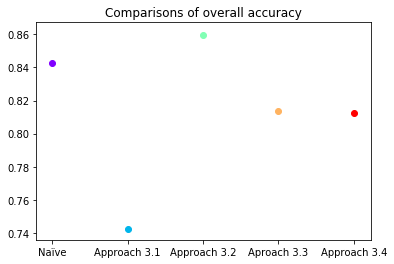

In [76]:

accuracy_results = [summary['accuracy_overall'] for summary in summaries]
plot_comparisons(approaches, accuracy_results, 'Comparisons of overall accuracy')

# Comparing overall accuracy accross gender

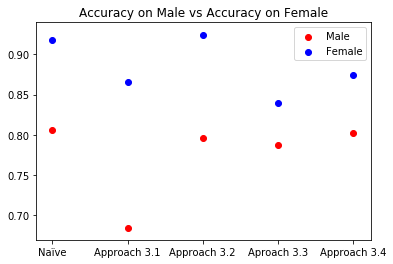

In [77]:

accuracy_male = [summary['accuracy_Male'] for summary in summaries]
accuracy_female = [summary['accuracy_Female'] for summary in summaries]
accuracy_results = [accuracy_male, accuracy_female]
plot_comparisons_groups(approaches, accuracy_results, 'Accuracy on Male vs Accuracy on Female', labels=['Male', 'Female'])

# Positive and negative rates accross gender

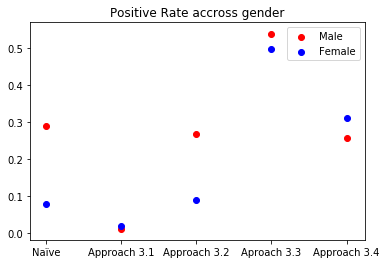

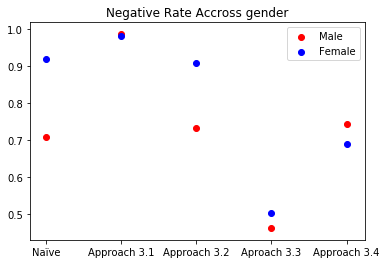

In [78]:
positive_rate_male = [summary['positive_rate_Male'] for summary in summaries]
positive_rate_female = [summary['positive_rate_Female'] for summary in summaries]
plot_comparisons_groups(approaches, [positive_rate_male, positive_rate_female], 'Positive Rate accross gender')


negative_rate_male = [summary['negative_rate_Male'] for summary in summaries]
negative_rate_female = [summary['negative_rate_Female'] for summary in summaries]
plot_comparisons_groups(approaches, [negative_rate_male, negative_rate_female], 'Negative Rate Accross gender')



# True positive and True negative rates accross gender

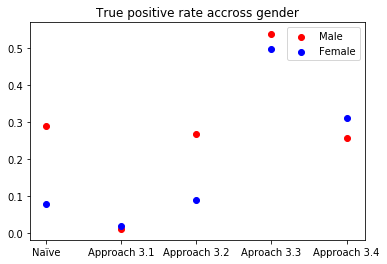

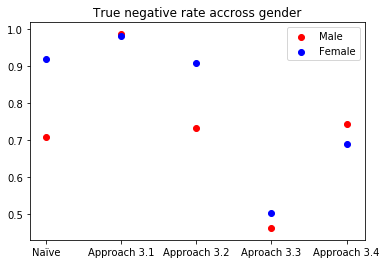

In [79]:
true_positive_rate_male = [summary['true_positive_rate_Male'] for summary in summaries]
true_positive_rate_female = [summary['true_positive_rate_Female'] for summary in summaries]
plot_comparisons_groups(approaches, [positive_rate_male, positive_rate_female], 'True positive rate accross gender')


true_negative_rate_male = [summary['true_negative_rate_Male'] for summary in summaries]
true_negative_rate_female = [summary['true_negative_rate_Female'] for summary in summaries]
plot_comparisons_groups(approaches, [negative_rate_male, negative_rate_female], 'True negative rate accross gender')

# True positive and true negative rates on the predicted positive or negative


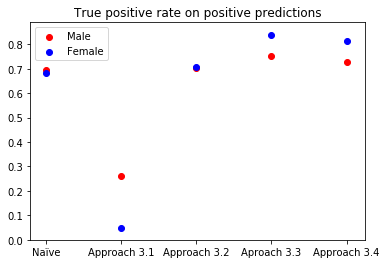

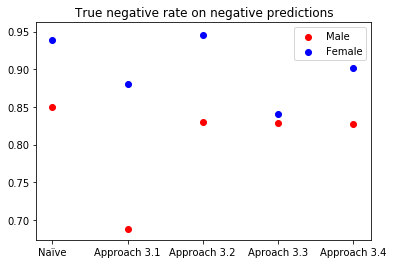

In [80]:
true_positive_rate_on_positive_predictions_male = [summary['true_positive_rate_on_positive_predictions_Male'] for summary in summaries]
true_positive_rate_on_positive_predictions_female = [summary['true_positive_rate_on_positive_predictions_Female'] for summary in summaries]
plot_comparisons_groups(approaches, [true_positive_rate_on_positive_predictions_male, true_positive_rate_on_positive_predictions_female], 'True positive rate on positive predictions')


true_negative_rate_on_negative_predictions_male = [summary['true_negative_rate_on_negative_predictions_Male'] for summary in summaries]
true_negative_rate_on_negative_predictions_female = [summary['true_negative_rate_on_negative_predictions_Female'] for summary in summaries]
plot_comparisons_groups(approaches, [true_negative_rate_on_negative_predictions_male, true_negative_rate_on_negative_predictions_female], 'True negative rate on negative predictions')

# Learning curves

https://www.dataquest.io/blog/learning-curves-machine-learning

# 4. Conclusion

We explored database re-balancing as a way to mitigate bias from our predictions. More advanced ways to mitigate bias in Machine Learning include custom loss functions and adversarial debiasing. To explore these techniques, follow the links below:

4.1 [Mitigating unwanted biases in Machine Learning through custom loss functions]()

4.2 [Mitigating unwanted biases in Machine Learning by adversarial learning]()

# 5. References

[1]. [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult)

[2]. [Google AI blog, Equal opportunity in Machine Learning](https://ai.googleblog.com/2016/10/equality-of-opportunity-in-machine.html)

[3]. [Towards Data Science, a Tutoria on Fairness in Machine Learning](https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb)

[4]. [Jeremy Kun, One definition of fairness in machine learning](https://jeremykun.com/2015/10/19/one-definition-of-algorithmic-fairness-statistical-parity/)

[5]. [Learning Curves for Machine Learning](https://www.dataquest.io/blog/learning-curves-machine-learning)

# Equalizing opportunity by setting equal true positive and true negative rates for different demographics

We will use the Receive Operating Characteristic(ROC) curve to understand how true positive and true negative rates affect each other accross different demographics


* Diagnostic ability of classifier
* Plots true positive rate (TPR) against the false positive rate (FPR) at various threshold settings
$$TPR = \frac{TP}{TP + FN}$$
$$FPR = \frac{FP}{FP + TN}$$
* Area under the ROC curve (AUC) - single number which reflects model's performance 

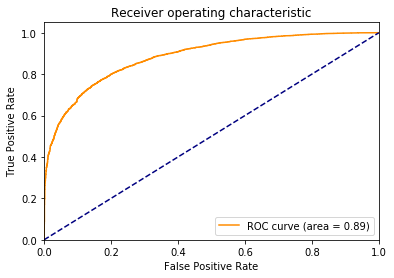

In [81]:
from sklearn import svm, metrics

#clf = svm.SVC()
clf = MLPClassifier()
clf.fit(x_train, y_train)
# obtain the learned decision function and evaluate it on the held-out data
y_pred_scores = clf.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_scores) # obtain false positive and true positive rates
area_under_curve = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % area_under_curve) # plot ROC curve
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [82]:
def plot_roc_curve(trained_predictor, X_test_list=None, Y_test_list=None, label_list = None, fignum=None):
    """
    Trained predictor must have .decision_function attribute
    """
    if fignum is not None:
        figure(fignum)
    for index in range(len(X_test_list)):
        X_test = X_test_list[index]
        Y_test = Y_test_list[index]
        assert X_test is not None and Y_test is not None, "X_test and Y_test cannot be None"
        y_pred_scores = trained_predictor.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred_scores) # obtain false positive and true positive rates
        area_under_curve = metrics.auc(fpr, tpr)
        label = "for gender = "+  label_list[index] if label_list is not None else ''
        #plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f) %s' % (area_under_curve, label)) # plot ROC curve
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f) %s' % (area_under_curve, label))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

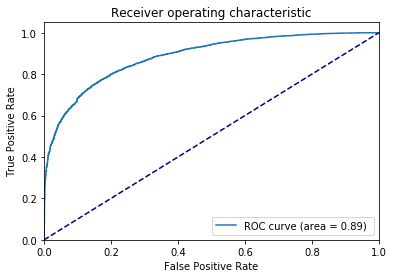

In [83]:
plot_roc_curve(clf, X_test_list = [x_test], Y_test_list = [y_test])

In [84]:
predictor = MLPClassifier()
predictor.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [85]:
def plot_roc_curves(trained_predictor, X_test, Y_test):
    combined = pd.concat([X_test, Y_test], axis=1)
    x_test_list, y_test_list, gender_labels = [], [], []
    for gender, gender_label in (("FEMALE", FEMALE_LABEL), ("MALE", MALE_LABEL)):
        with_gender = combined[combined['sex'] == gender_label]
        x_test = with_gender.drop(['salary'], axis=1)
        y_test = with_gender['salary']
        x_test_list.append(x_test)
        y_test_list.append(y_test)
        gender_labels.append(gender)
    plot_roc_curve(predictor, X_test_list=x_test_list, Y_test_list=y_test_list,label_list=gender_labels)

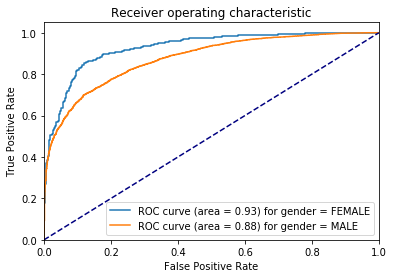

In [86]:
plot_roc_curves(predictor, x_test, y_test)

In [87]:
combined = pd.concat([x_test, y_test], axis=1)
combined.head()

,age,fnlwgt,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,relationship_0,...,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13,salary
34374,-0.798015,0.055267,-0.438122,0,1,0.0,0.0,0.754701,0,0,...,0,1,0,0,0,0,0,0,0,1
27460,-0.419735,-0.669283,-2.004996,0,1,0.0,0.0,-0.078120,0,0,...,0,0,0,0,0,0,0,0,0,1
26240,-1.327607,1.472181,-0.046403,1,1,1.0,0.0,-0.078120,0,0,...,0,0,0,0,0,0,0,0,0,1
11150,-0.798015,0.065841,-0.438122,1,0,0.0,0.0,-0.078120,0,0,...,0,0,0,1,0,0,0,0,0,1
8089,1.925601,-0.717599,-0.438122,0,1,0.0,0.0,-0.494531,0,0,...,1,0,0,0,0,0,0,0,0,1


In [88]:
with_gender = combined[combined['sex'] == MALE_LABEL]
with_gender.head()

,age,fnlwgt,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,relationship_0,...,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13,salary
34374,-0.798015,0.055267,-0.438122,0,1,0.0,0.0,0.754701,0,0,...,0,1,0,0,0,0,0,0,0,1
27460,-0.419735,-0.669283,-2.004996,0,1,0.0,0.0,-0.078120,0,0,...,0,0,0,0,0,0,0,0,0,1
26240,-1.327607,1.472181,-0.046403,1,1,1.0,0.0,-0.078120,0,0,...,0,0,0,0,0,0,0,0,0,1
8089,1.925601,-0.717599,-0.438122,0,1,0.0,0.0,-0.494531,0,0,...,1,0,0,0,0,0,0,0,0,1
24377,-1.100639,-0.846189,1.128753,1,1,0.0,0.0,-1.743763,0,0,...,0,0,0,0,0,0,0,0,0,1


In [89]:
with_gender.drop(['salary'], axis=1).head()

,age,fnlwgt,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,relationship_0,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
34374,-0.798015,0.055267,-0.438122,0,1,0.0,0.0,0.754701,0,0,...,0,0,1,0,0,0,0,0,0,0
27460,-0.419735,-0.669283,-2.004996,0,1,0.0,0.0,-0.078120,0,0,...,0,0,0,0,0,0,0,0,0,0
26240,-1.327607,1.472181,-0.046403,1,1,1.0,0.0,-0.078120,0,0,...,0,0,0,0,0,0,0,0,0,0
8089,1.925601,-0.717599,-0.438122,0,1,0.0,0.0,-0.494531,0,0,...,0,1,0,0,0,0,0,0,0,0
24377,-1.100639,-0.846189,1.128753,1,1,0.0,0.0,-1.743763,0,0,...,0,0,0,0,0,0,0,0,0,0


# Model Fusion

Soft Voting/Majority Rule classifier for unfitted estimators.

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score

clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
clf4 = MLPClassifier()
clf5 = svm.SVC()

/Users/audace/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [91]:
(x_train, y_train), (x_test, y_test) = get_gender_category_ratio_balanced_dataset(datav3)

In [92]:
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('MLP', clf4), ('svc', clf5)], voting='hard')
eclf1 = eclf1.fit(x_train, y_train)

In [93]:
print('Voting Accuracy: ', accuracy_score(y_test, eclf1.predict(x_test)))

Voting Accuracy:  0.8192260510761682


/Users/audace/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [101]:
# Model persistence
import pickle

def storeModels(models=None, names=None):
    filenames = []
    for model, filename in zip(models, names):
        filenames.append(pickle.dump(model))
    return filenames
        
def loadModels(names):
    result = []
    for filename in filenames:
        result.append(pickle.load(filename))
        

In [102]:
storeclf1 = True
if storeclf1:
    storeModels(models=[eclf1], names='eclf1')

TypeError: write() argument must be str, not bytes

In [ ]:
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1)
rf = RandomForestClassifier(n_estimators=50, random_state=1)
gnb = GaussianNB()
mlp = MLPClassifier()
svc = svm.SVC()

for model in [lr, rf, gnb, mlp, svc]:
    model.fit(x_train, y_train)

In [ ]:
modelnames = ['lr', 'rf', 'gnb', 'mlp', 'svc']
models = [lr, rf, gnb, mlp, svc]

In [ ]:
_storemodels = True
if _storemodels:
    storemodels(models=models, names=modelnames)

In [ ]:
_loadmodels = False
if _loadmodels:
    models = loadmodels(modelnames)

In [ ]:
for model_name, model in [('LR', lr), ('RF', rf), ('GNB', gnb), ('MLP', mlp), ('svc', svc)]:
    print(model_name, 'accuracy: ', accuracy_score(y_test, model.predict(x_test)))

In [ ]:
def 

# Comparing model performances on classification tasks

For most classification problems, the following models are to use:

In [ ]:
from IPython.display import Image

In [ ]:
Image(filename='images/ml_problem_groups.png', width= 500, height= 500)

This is a classification problem, therefore, the different classifiers that we can use are 

- Support Vector Machines(SVMs), 
- Decision tree learners, 
- Instance based learners, 
- Generalized linear models, and 
- Artificial neural networks. 

We are going to use one from each category, in order to get a comparison of how these models perform